# Clean data 

This notebook is dedicated to perform the data cleaning for the Airbnb  removing inaccurate and irrelevant data of the project.

In [1]:
# import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# accessing google with the files 
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive/STAT447 - Predicting Airbnb prices in Vancouver - Team 10/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the data from the csv file 
df_raw = pd.read_csv(drive_path + '01_downloaded_data_airbnb_vancouver.csv')
df_raw.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13358.0,https://www.airbnb.com/rooms/13358,20230314070648,2023-03-14,city scrape,Designer Styled One Bedroom Downtown Vancouver,<b>The space</b><br />This suites central loca...,NaN,https://a0.muscache.com/pictures/40034c18-0837...,52116,...,4.80,4.92,4.68,22-311727,f,1.0,1.0,0.0,0.0,2.86
1,13490.0,https://www.airbnb.com/rooms/13490,20230314070648,2023-03-14,city scrape,Vancouver's best kept secret,This apartment rents for one month blocks of t...,"In the heart of Vancouver, this apartment has ...",https://a0.muscache.com/pictures/73394727/79d5...,52467,...,4.97,4.78,4.88,NaN,f,1.0,1.0,0.0,0.0,0.67
2,14267.0,https://www.airbnb.com/rooms/14267,20230314070648,2023-03-14,previous scrape,EcoLoft Vancouver,"The Ecoloft is located in the lovely, family r...",We live in the centre of the city of Vancouver...,https://a0.muscache.com/pictures/3646de9b-934e...,56030,...,4.68,4.77,4.71,21-156500,t,1.0,1.0,0.0,0.0,0.22
3,14424.0,https://www.airbnb.com/rooms/14424,20230314070648,2023-03-14,city scrape,Spacious one-bedroom in sought-after Strathcona,<b>The space</b><br />Welcome to Strathcona --...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,56709,...,4.72,4.60,4.74,19-162091,f,4.0,4.0,0.0,0.0,1.66
4,16254.0,https://www.airbnb.com/rooms/16254,20230314070648,2023-03-14,city scrape,Close to PNE/Hastings Park Garden level suite,2 Bedroom garden level guest suite.(lower leve...,"Good Eats, Cute Shops and all the personality ...",https://a0.muscache.com/pictures/d0cdc9b4-5937...,63238,...,5.00,4.86,4.29,19-162421,f,1.0,1.0,0.0,0.0,0.12


In [3]:
# investigate number of duplicates in the data
# another idea was to check and remove duplicates in lat, lon and host_id this would however remove Airbnb where a host offers two or more rooms in the same house
sum(df_raw.duplicated())

0

In [4]:
# investigate the number of missing values for each column 
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5977 entries, 0 to 5976
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5975 non-null   float64
 1   listing_url                                   5977 non-null   object 
 2   scrape_id                                     5977 non-null   object 
 3   last_scraped                                  5977 non-null   object 
 4   source                                        5977 non-null   object 
 5   name                                          5977 non-null   object 
 6   description                                   5952 non-null   object 
 7   neighborhood_overview                         3998 non-null   object 
 8   picture_url                                   5977 non-null   object 
 9   host_id                                       5977 non-null   i

The features neighbourhood_group_cleansed, bathrooms and calendar_updated should be dropped as they only have 1 or 2 non-null values.

Irrelevant data for our project goal of predicting Airbnb prices in Vancouver identified in the initial investigation is the following

* scraping data: scrape_id, last_scraped, source, calendar_last_scraped
* url data: listing_url, picture_url, host_url, host_thumbnail_url, host_picture_url
* extensive host details: host_id, host_name, host_about, host_location, host_has_profile_pic, calculated_host_listings_count, calculated_host_listings_count_entire_homes,  calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, host_listings_count,    host_total_listings_count, host_verifications, host_response_rate,host_acceptance_rate
* textual data that would be diffitult to process further: bathrooms_text, host_response_time, description, name
* additional information on neighbourhood (neighbourhood_cleansed is complete and clean): neighbourhood_overview, neighbourhood, host_neighbourhood
* additional data on minimum and maximum nights: minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm 
* additional availability and review data (keep availability for the next year and number of reviews in the last year):
availability_30, availability_60, availability_90, number_of_reviews, number_of_reviews_l30d, reviews_per_month, first_review, last_review
* additional information on accomodates and beds: bedrooms

In [5]:
# define the filter and formatiing function based on the findings

def filter_and_format(df):
    '''
    @inputs: panda dataframe (df of listing.csv)
    @outputs : pandas dataframe 
    @purpose: given a city's airbnb dataset, this function cleans the data
          it will keep relevant columns and formats the columns
    '''

    # only consider Airbnbs with id
    df = df[df.id.notna()]

    #check for duplicates using listing id, if exist remove duplicate
    df.drop_duplicates('id', keep='last', inplace=True)

    # set id as index and drop entries with nan values
    df = df.set_index('id')

    #only include columns of interest
    cols_to_keep = ['host_since', 'host_is_superhost','host_identity_verified','neighbourhood_cleansed',
                    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 
                    'has_availability', 'availability_365', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable' ]
    df = df[cols_to_keep]

    # clean up data types
    # drop $ in price and convert to float
    df.loc[:, 'price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)


    # convert date columns to datetime
    df["host_since"]  = pd.to_datetime(df.host_since)

    # convert the boolean column to 1 and 0 
    df['host_is_superhost'] = df['host_is_superhost'].replace({'f':0, 't':1})

    # convert accomodates and beds to int
    df = df[df['accommodates'].notna()]
    df = df[df['beds'].notna()]
    df.loc[:, 'accommodates'] = df['accommodates'].astype('int')
    df.loc[:, 'beds'] = df['beds'].astype('int')

    # change the data types of the nights to int
    df = df[df['minimum_nights'].notna()]
    df = df[df['maximum_nights'].notna()]
    df = df[df['availability_365'].notna()]
    df.loc[:, 'minimum_nights'] = df['minimum_nights'].astype('int')
    df.loc[:, 'maximum_nights'] = df['maximum_nights'].astype('int')
    df.loc[:, 'availability_365'] = df['availability_365'].astype('int')

    # rename the columns for easier handling
    df.rename(columns={"minimum_nights":'min_nights', "maximum_nights":'max_nights',"neighbourhood_cleansed": "neighbourhood", "availability_365":"avail_365", "number_of_reviews_ltm":"no_reviews_year"}, inplace=True)

    return df

In [6]:
df_filter = filter_and_format(df_raw)
df_filter

,host_since,host_is_superhost,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,beds,...,avail_365,no_reviews_year,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
id,,,,,,,,,,,,,,,,,,,,,
1.335800e+04,2009-11-07,1.0,t,West End,49.282010,-123.126690,Entire condo,Entire home/apt,2,1,...,212,10.0,4.68,4.75,4.80,4.84,4.80,4.92,4.68,f
1.349000e+04,2009-11-08,1.0,t,Kensington-Cedar Cottage,49.256220,-123.066070,Entire rental unit,Entire home/apt,2,1,...,152,4.0,4.92,4.93,4.96,4.96,4.97,4.78,4.88,f
1.426700e+04,2009-11-20,0.0,t,Kensington-Cedar Cottage,49.249220,-123.081390,Entire home,Entire home/apt,4,2,...,0,0.0,4.76,4.84,4.68,4.90,4.68,4.77,4.71,t
1.442400e+04,2009-11-23,0.0,t,Downtown Eastside,49.279210,-123.088350,Entire guest suite,Entire home/apt,2,1,...,70,7.0,4.69,4.84,4.93,4.85,4.72,4.60,4.74,f
1.625400e+04,2009-12-15,0.0,t,Hastings-Sunrise,49.277210,-123.040860,Entire guest suite,Entire home/apt,4,3,...,194,2.0,4.57,4.86,4.57,4.86,5.00,4.86,4.29,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.452841e+17,2023-03-11,0.0,f,Riley Park,49.237248,-123.104728,Entire guest suite,Entire home/apt,4,2,...,308,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t
8.458546e+17,2015-11-20,0.0,t,Mount Pleasant,49.269547,-123.110062,Entire rental unit,Entire home/apt,2,1,...,240,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t
8.458918e+17,2016-09-28,0.0,t,Victoria-Fraserview,49.216332,-123.055613,Entire home,Entire home/apt,8,4,...,358,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t


Response rates are between 0 and 1 without outliers.

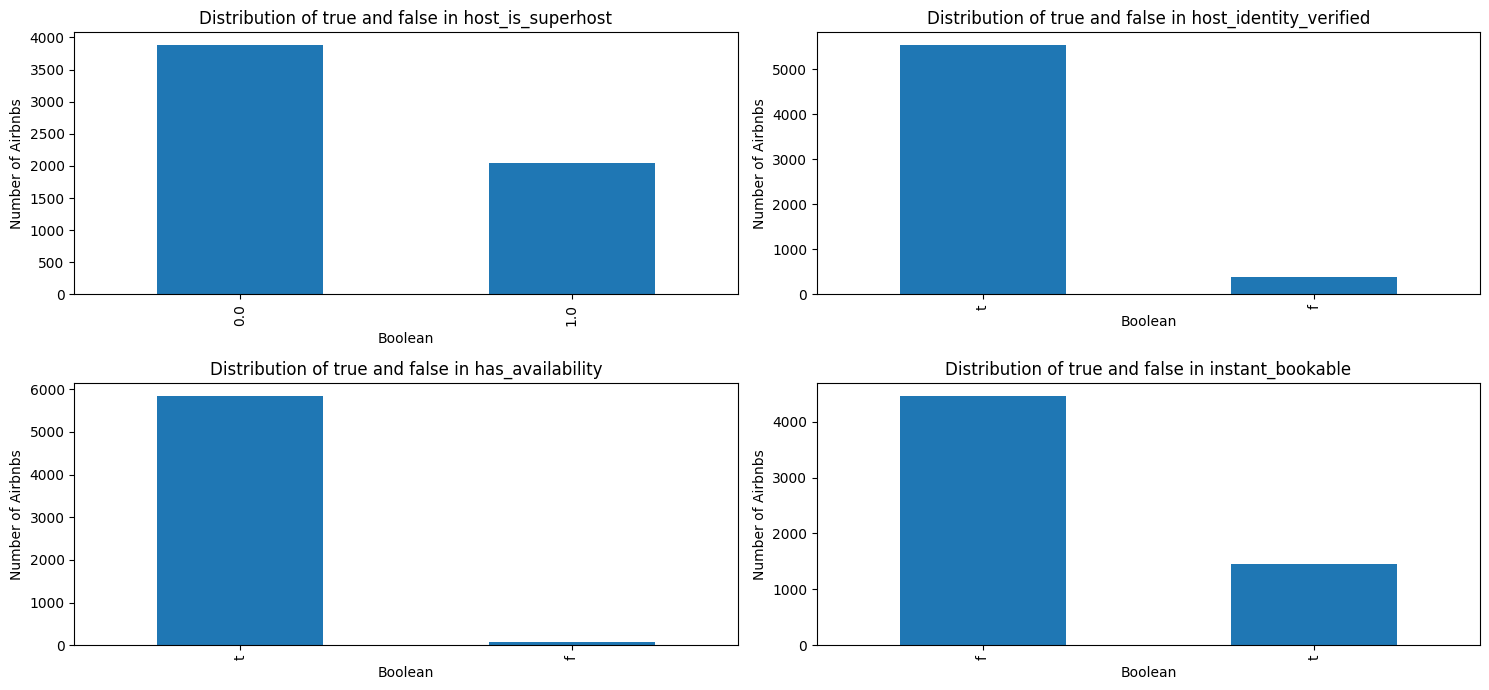

In [7]:
# check boolean columns for only true and false values
boolean_columns = ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']
plt.figure(figsize=(15,7))
for i, column in enumerate(boolean_columns):
  plt.subplot(2, 2, i+1)
  plt.title("Distribution of true and false in "+ column)
  plt.ylabel("Number of Airbnbs")
  plt.xlabel("Boolean")
  df_filter[column].value_counts().plot(kind="bar")

plt.tight_layout()

The boolean columns only contain true and false values, but only is superhost shows differentiability potential so the others will be dropped.

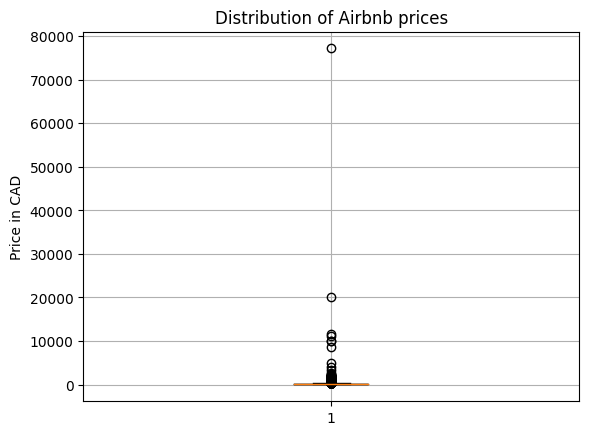

In [8]:
# check the distribution of the price
plt.title("Distribution of Airbnb prices")
plt.boxplot(df_filter.price)
plt.grid()
plt.ylabel("Price in CAD")
plt.show()

The price distribution shows outliers, so the decision was taken to take only Airbnbs with prices up to the 95th percentile.

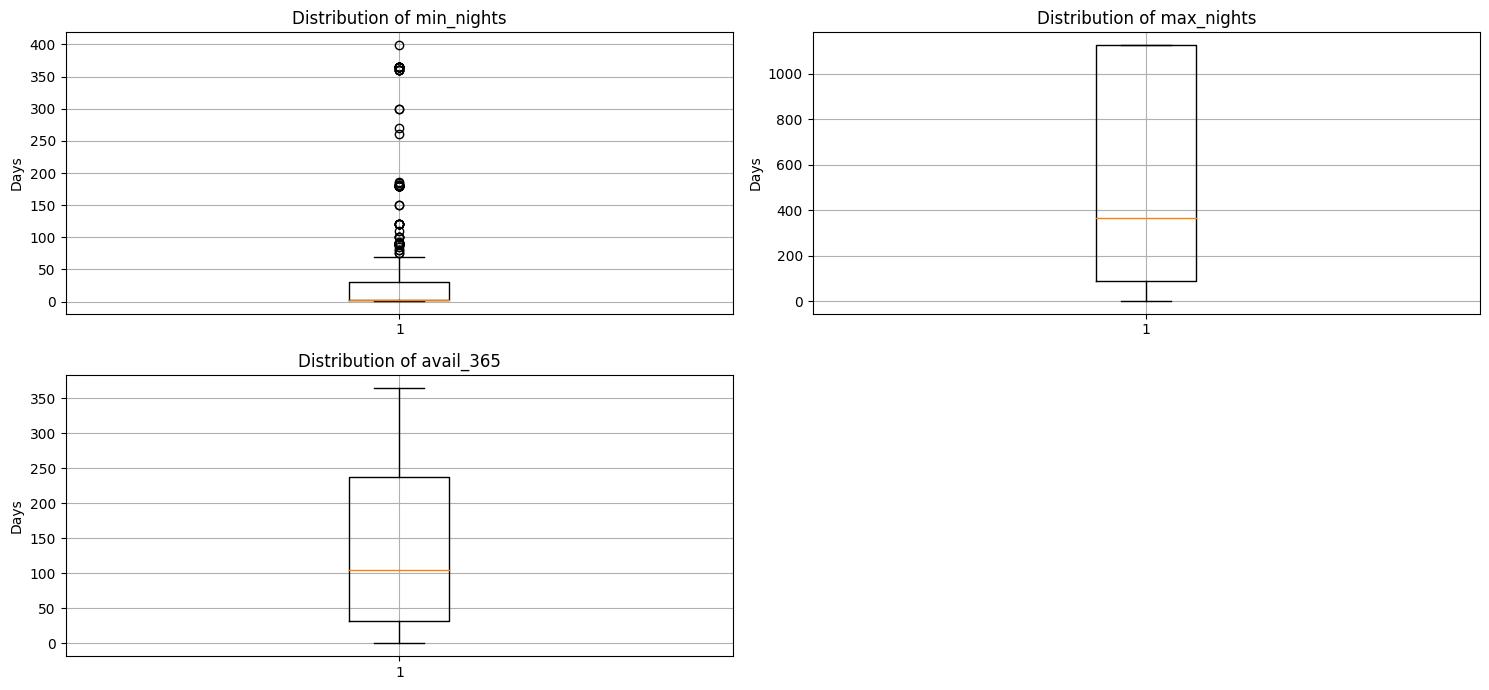

In [9]:
# check the day columns for outliers
day_columns = ['min_nights', 'max_nights', 'avail_365']
plt.figure(figsize=(15,7))
for i, column in enumerate(day_columns):
  plt.subplot(2, 2, i+1)
  plt.grid()
  plt.title("Distribution of " + column)
  plt.ylabel("Days")
  plt.boxplot(df_filter[column])

plt.tight_layout()

The distribution of minimum and maximum nights is reasonable and the availabilities in the next year are within the 365 day range.

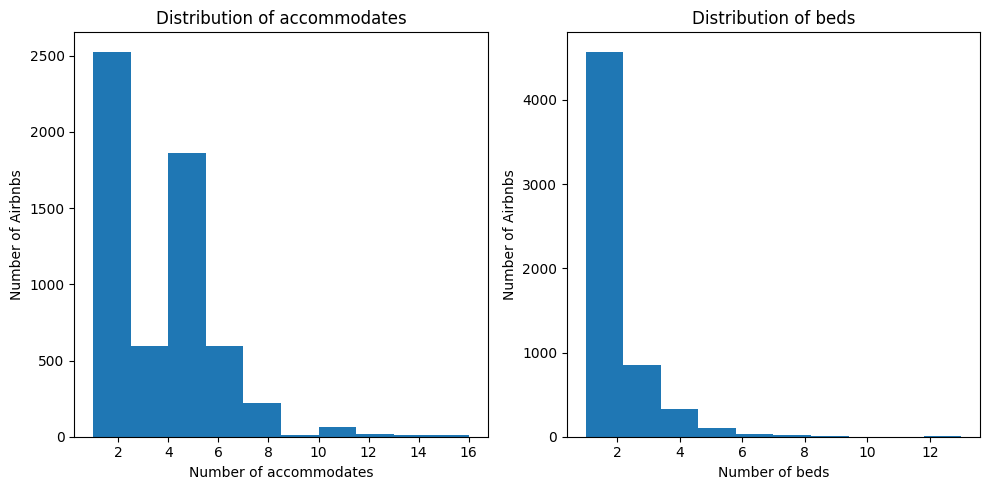

In [10]:
# plot the distribution of accomodates, beds and bedrooms
plt.figure(figsize=(10,5))
plt.subplot(1, 2,1 )
plt.title("Distribution of accommodates")
plt.xlabel("Number of accommodates")
plt.ylabel("Number of Airbnbs")
plt.hist(df_filter.accommodates)

plt.subplot(1, 2, 2)
plt.title("Distribution of beds")
plt.xlabel("Number of beds")
plt.ylabel("Number of Airbnbs")
plt.hist(df_filter.beds)
plt.tight_layout()

There are some big Airbnbs with a high number of accommodates for instance and the decision was taken to remove these at the 8 accomodate mark.

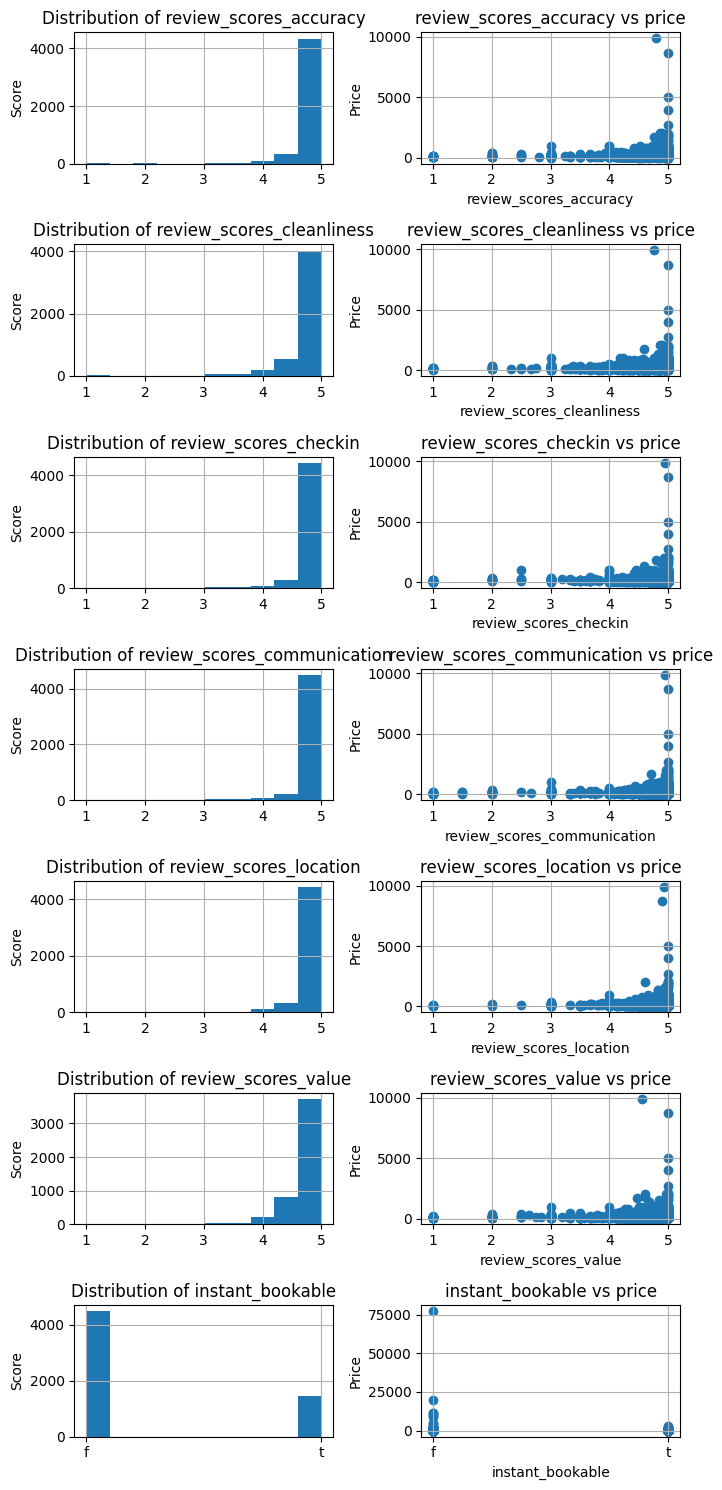

In [11]:
# plot the distributions of the review scores 
plt.figure(figsize=(7,15))
i = 1
for column in df_filter.iloc[:,18:25][df_filter.iloc[:,18:25].notna()].columns:
  plt.subplot(7, 2, i)
  plt.grid()
  plt.title("Distribution of " + column)
  plt.ylabel("Score")
  plt.hist(df_filter[column])

  plt.subplot(7, 2, i+1)
  plt.grid()
  plt.title(column + " vs price")
  plt.scatter(df_filter[column], df_filter.price)
  plt.ylabel("Price")
  plt.xlabel(column)
  i += 2

plt.tight_layout()

The rating scores are within the expected 1 - 5 rating range but they follow a similar distribution also compared to the price so only the overall rating will be kept.

In [12]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5925 entries, 13358.0 to 8.459609502800886e+17
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   host_since                   5925 non-null   datetime64[ns]
 1   host_is_superhost            5925 non-null   float64       
 2   host_identity_verified       5925 non-null   object        
 3   neighbourhood                5925 non-null   object        
 4   latitude                     5925 non-null   float64       
 5   longitude                    5925 non-null   float64       
 6   property_type                5925 non-null   object        
 7   room_type                    5925 non-null   object        
 8   accommodates                 5925 non-null   int64         
 9   beds                         5925 non-null   int64         
 10  amenities                    5925 non-null   object        
 11  price             


There are 1025 missing value of the of the average rating score. Hence, we decided to predict the missing value with a simple linear regression. To not make it too comlicated, we'll only use several of the numerical features such as the price, number of reviews, minimum nights, accomodates, and availability_365

In [13]:
# create a function to predict the average rating
def predict_average_rating(df):
    '''
    @inputs: panda dataframe (df of listing.csv)
    @outputs : pandas dataframe 
    @purpose: this function will predict missing values in the average rating score of an Airbnb
              using reduced selected features
    '''
    
    
    sub_df = df[['accommodates', 'avail_365', 'price', 'no_reviews_year', 'min_nights', 'review_scores_rating']]
    # split datasets
    train_data = sub_df[sub_df['review_scores_rating'].notnull()] 
    test_data  = sub_df[sub_df['review_scores_rating'].isnull()]

    # define X
    X_train = train_data.drop('review_scores_rating', axis=1)
    X_test  = test_data.drop('review_scores_rating', axis=1)

    # define y
    y_train = train_data['review_scores_rating']

    # instantiate linear regression
    linreg = LinearRegression()

    # fit model to training data  
    linreg.fit(X_train, y_train)

    # making predictions
    y_test = linreg.predict(X_test)

    y_test = pd.DataFrame(y_test)
    y_test.columns = ['review_scores_rating']

    # make the index of X_test to an own dataframe
    prelim_index = pd.DataFrame(X_test.index)
    prelim_index.columns = ['prelim']

    # ... and concat this dataframe with y_test
    y_test = pd.concat([y_test, prelim_index], axis=1)
    y_test.set_index(['prelim'], inplace=True)
    y_test.head()

    new_test_data = pd.concat([X_test, y_test], axis=1)

    new_test_data['review_scores_rating'].isna().sum()

    # combine train and test data back to a new sub df
    sub_df_new = pd.concat([new_test_data, train_data], axis=0)

    # prepare the multiple columns before concatening
    df.drop(['accommodates', 'avail_365', 'price', 'no_reviews_year', 'min_nights', 'review_scores_rating'],  axis=1, inplace=True)
    # concate back to complete dataframe
    sub_df_new=round(sub_df_new)
    df = pd.concat([sub_df_new, df], axis=1)
    
    return df

In [17]:
# define the cleaning function based on the findings

def cleaning(df):
    '''
  @inputs: panda dataframe (df of listing.csv)
  @outputs : pandas dataframe 
  @purpose: given a city's airbnb filtered and formatted dataset, the values are cleaned up further after investigating the value in detail
  '''

    # remove price outliers over the 95th percentile
    df = df[df.price <= np.percentile(df.price, 95)]

    df = df.drop(columns =['host_identity_verified', 'has_availability', 'instant_bookable'])

    df = df.drop(columns=['review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'])

    df = df[df.accommodates <= 8]

    df = predict_average_rating(df)
    
    # recategorizing property type
    property_type_map = {'Entire condo': 'Apartment', 'Entire rental unit': 'Rental Unit', 'Entire home': 'House', 'Entire guest suite': 'Guest House', 'Private room in home': 'House', 'Entire loft': 'Apartment',
    'Private room in rental unit': 'Rental Unit', 'Entire townhouse': 'Townhouse', 'Private room in condo': 'Apartment', 'Entire serviced apartment': 'Apartment', 'Entire guesthouse': 'Guest House','Private room in villa': 'Other', 
    'Private room in guest suite': 'Guest House','Private room in townhouse': 'Townhouse', 'Entire villa': 'Other', 'Room in boutique hotel': 'Other','Private room in bed and breakfast': 'Other', 'Entire bungalow': 'House', 
    'Shared room in rental unit': 'Rental Unit', 'Entire place': 'Other', 'Tiny home': 'Other','Room in aparthotel': 'Other', 'Entire vacation home': 'House', 'Private room in bungalow': 'House', 'Entire timeshare': 'Other',
    'Private room in guesthouse': 'Guest House', 'Shared room in loft': 'Apartment', 'Entire cottage': 'House','Shared room in hostel': 'Other', 'Camper/RV': 'Other', 'Shared room in home': 'House', 'Private room in resort': 'Other',
    'Private room in serviced apartment': 'Apartment', 'Room in bed and breakfast': 'Other', 'Private room in hostel': 'Other', 'Room in hotel': 'Other','Private room in loft': 'House', 'Boat': 'Other',
    'Private room in vacation home': 'House', 'Shared room in bed and breakfast': 'Other', 'Private room in casa particular': 'Other', 'Shared room in villa': 'House', 'Private room in boat': 'Other','Tower': 'Other',
    'Entire cabin': 'House','Private room in tiny home': 'Other', 'Private room in camper/rv': 'Other', 'Floor': 'Other','Private room in cottage': 'House','Shared room in condo': 'Apartment'}

    df['property_type'] = df['property_type'].map(property_type_map)
    df = df.dropna()
    # remove NaNs

    return df

In [18]:
df_clean = cleaning(df_filter)
df_clean

,accommodates,avail_365,price,no_reviews_year,min_nights,review_scores_rating,host_since,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,beds,amenities,max_nights
1.802400e+04,6,17,150.0,0.0,30,5.0,2010-01-10,0.0,Kensington-Cedar Cottage,49.247810,-123.072410,House,Private room,3,"[""Freezer"", ""Fire pit"", ""Shower gel"", ""Smoke a...",365
7.966030e+05,1,0,30.0,0.0,30,5.0,2012-11-20,0.0,West End,49.280870,-123.135250,Rental Unit,Shared room,1,"[""Elevator"", ""Heating"", ""TV with standard cabl...",60
2.217245e+06,2,27,99.0,0.0,2,5.0,2014-01-14,0.0,Fairview,49.259997,-123.141666,Rental Unit,Private room,1,"[""Mountain view"", ""Free dryer \u2013 In unit"",...",10
2.710628e+06,2,326,124.0,0.0,3,5.0,2013-06-25,0.0,Hastings-Sunrise,49.265231,-123.035652,Guest House,Private room,1,"[""Aveeno conditioner"", ""42\"" TV with Netflix"",...",28
2.876573e+06,2,97,165.0,0.0,30,5.0,2009-11-10,0.0,Downtown,49.289450,-123.126650,Rental Unit,Entire home/apt,1,"[""Free parking on premises"", ""Wifi"", ""Building...",365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.372551e+17,2,153,250.0,1.0,2,5.0,2017-06-30,0.0,Kitsilano,49.268908,-123.174211,House,Private room,1,"[""Freezer"", ""Shared backyard \u2013 Fully fenc...",365
8.387495e+17,5,88,146.0,1.0,2,5.0,2022-04-07,0.0,Downtown,49.278841,-123.107399,Rental Unit,Entire home/apt,3,"[""Freezer"", ""Trash compactor"", ""Coffee maker: ...",180
8.394611e+17,2,39,96.0,1.0,1,5.0,2023-03-03,0.0,Downtown,49.279316,-123.119717,Apartment,Private room,1,"[""Paid parking lot on premises \u2013 1 space""...",365
8.406150e+17,4,75,97.0,1.0,1,5.0,2023-02-06,0.0,Renfrew-Collingwood,49.238211,-123.037842,House,Entire home/apt,2,"[""Books and reading material"", ""Security camer...",60


In [19]:
# save the cleaned data to a dataframe
df_clean.to_csv(drive_path + "02a_cleaned_data_airbnb_vancouver.csv", index=True)